## Data fields & description:
- Project Number: the unique project id
- Project Title: the project name (Mandatory)
- Project Title English: the project name in English (Optional)
- Reponsible Applicant: the person who submitted the research proposal to the SNSF (Mandatory)
- Funding Instrument: funding schemes for research and scientific communication
- Funding Instrument Hierarchy: top level hierarchy funding instrument
- Institution: the research institution where the project will largely be carried out
- University: the University where the project will largely be carried out. **This field is only filled if the research is carried out at a Swiss institution, otherwise the field remains blank. In the case of mobility fellowships, it is generally left empty.**
- Discipline Number: number of the discipline
- Discipline Name: name of the discipline
- Discipline Name Hierarchy: top level of discipline
- Start Date: the starting date of the project
- End Date: the actual end date of the project
- Approved Amount: the total approved money spent for the project. **This amount is not indicated in the case of mobility fellowships.**
- Keywords: unstructured field.

In [20]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
import folium
import requests
import re
%matplotlib inline

In [21]:
# Define constants
GEONAMES_SEARCH_URL = 'http://api.geonames.org/searchJSON'
GOOGLE_SEARCH_URL = 'https://maps.googleapis.com/maps/api/place/textsearch/json'
GOOGLE_GEOCODE_URL = 'https://maps.googleapis.com/maps/api/geocode/json'

In [22]:
# load the p3
df = pd.read_csv('./data/P3_GrantExport.csv', sep=";")

In [23]:
#Save number of entries in the beginning
n_begin=df.shape[0]
n_begin

63969

The documentation of fields mentions that institutes from outside Switzerland don't have an entry in University. So it's safe to throw away all rows has 'nicht zuteilbar - NA' in university column.

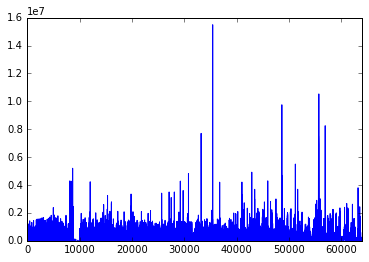

In [24]:
df = df[df['Approved Amount'] != 'data not included in P3']
df['Approved Amount'] = df['Approved Amount'].astype(float)
df['Approved Amount'].plot()

- 'Nicht zuteilbar - NA' : not assignable

So we remove this field!

In [25]:
df_Nicht = df[df['University'] == 'Nicht zuteilbar - NA']
#Check the percentage of overall data that will be thrown away because of 'nicht zuteilbar - NA'
print(len(df_Nicht)/df.shape[0]*100)

4.890781959705234


In [26]:
df_null = df[df['University'].isnull()]
#Check the percentage of overall data where 'University' field is empty
print(len(df_null)/df.shape[0]*100,end="")
print(' percent of all data has no University name data')

4.110518479428561 percent of all data has no University name data


In [27]:
#Firstly delete data with 'nicht zuteilbar - NA' ,then null data
df = df[df['University'] != 'Nicht zuteilbar - NA']
df = df[df['University'].notnull()]

In [28]:
#Check number of entries left for working on data and the percentage of deleted data from overall data
n_left=df.shape[0]
print(n_left,end="")
print(" rows of data will be used for further processing")
print("And this constitutes ", end="")
print(n_left/n_begin*100,end="")
print(" percent of overall data that we are provided in the beginning")

48283 rows of data will be used for further processing
And this constitutes 75.47874751832919 percent of overall data that we are provided in the beginning


In [29]:
universities = list(df['University'].unique())
for university in universities:
    if ' - ' not in university:
        df.loc[df['University'] == university,'University'] = university[::-1].replace(" "," - ",1)[::-1]
universities = list(df['University'].unique())

In [30]:
print('Number of unique universities from dataset we will be working on is ' + str(len(universities)))

Number of unique universities from dataset we will be working on is 76


## GeoNames Search Webservice:
GeoNames api offers services in XML and JSON format. We use JSON format as it is easier to extract data from it.

In [38]:
def search(url, params):
    """ This function returns a json file containing the geographical results from the
    Geonames or google map websites """
    try:
        response = requests.get(url, params)
    except:
        raise ServiceException(url, params)
    return response.json()

In [60]:
lst = []
for university in universities:
    params = {'q': university, 'maxRows': 1, 'country': 'CH', 'username': 'sorooshafiee'}
    response = search(GEONAMES_SEARCH_URL, params)
    lst.append(response['totalResultsCount'])
print('Number of the recovered contons from the university name: {}/{}'.format(sum(x != 0 for x in lst), len(lst)))

Number of the recovered contons from the university name: 5/76


## Google API


In [40]:
def get_geonames(url, params, types):
    """ This function returns the filtered address component """
    try:
        response = requests.get(url,params)
    except:
        raise ServiceException(url, params)
    address_comps = response.json()['results'][0]['address_components']
    filter_method = lambda x: len(set(x['types']).intersection(list(types)))
    return filter(filter_method, address_comps)

In [61]:
# api_key.txt keeps the api_key
with open('data/api_key.txt', 'r') as in_file:
    api_key = in_file.read()

In [62]:
match = {}
response = {}
unmatch = []
types = ['administrative_area_level_1']
for university in universities:
    params = {'key' : api_key, 'query' : university}
    response[university] = search(GOOGLE_SEARCH_URL, params)
    if response[university]['status'] == 'OK':
        location = response[university]['results'][0]['geometry']['location']
        latlng = str(round(location['lat'],2)) + ',' + str(round(location['lng'],2))
        params = {'latlng': latlng}
        address_comps = get_geonames(GOOGLE_GEOCODE_URL, params, types)
        canton = list(address_comps)[0]['long_name']
        match.update({university: canton})
    else:   
        unmatch.append(university)
print('Number of the recovered contons from the university name: {}/{}'.format(len(match), len(universities)))

Number of the recovered contons from the university name: 60/76


In [63]:
## Now we make some changes on the string content of the university names to make them in the useful form for the search
## that gives better results.
new_match = []
for university in unmatch:
    print(university)
    sub_str = re.search(r'(.+?) \-\ (\w+)', university).group(1)
    if '(' in sub_str:
        sub_str = re.search(r'(.+?) \((.+?)\)', sub_str).group(1)
    params = {'key' : api_key, 'query' : sub_str}
    response[university] = search(GOOGLE_SEARCH_URL, params)
    if response[university]['status'] == 'OK':
        location = response[university]['results'][0]['geometry']['location']
        latlng = str(round(location['lat'],2)) + ',' + str(round(location['lng'],2))
        params = {'latlng': latlng}
        address_comps = get_geonames(GOOGLE_GEOCODE_URL, params, types)
        canton = list(address_comps)[0]['long_name']
        match.update({university: canton})
        new_match.append(university)
unmatch = [university for university in unmatch if university not in new_match]
print('Number of the recovered contons from the university name: {}/{}'.format(len(match), len(universities)))

NPO (Biblioth., Museen, Verwalt.) - NPO
Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL
Weitere Institute - FINST
Firmen/Privatwirtschaft - FP
Physikal.-Meteorolog. Observatorium Davos - PMOD
Swiss Center for Electronics and Microtech. - CSEM
Weitere Spitäler - ASPIT
AO Research Institute - AORI
Forschungsanstalten Agroscope - AGS
Zürcher Fachhochschule (ohne PH) - ZFH
Forschungsinstitut für Opthalmologie - IRO
Forschungskommission - SAGW
Pädag. Hochschule Tessin (Teilschule SUPSI) - ASP
Schweizer Kompetenzzentrum Sozialwissensch. - FORS
Pädagogische Hochschule Wallis - PHVS
Staatsunabh. Theologische Hochschule Basel - STHB
Number of the recovered contons from the university name: 65/76


In [67]:
new_match = []
for university in unmatch:
    sub_str = re.search(r'(.+?) \-\ (\w+)', university).group(1)
    if '(' in sub_str:
        sub_str = re.search(r'(.+?) \((.+?)\)', sub_str).group(1)
    if '.' in sub_str:
        if sub_str.endswith('.'):
            sub_str = re.search(r'(.+?) (\w+)\.', sub_str).group(1)
        else:
            sub_str = sub_str[sub_str.rfind('.')+2::]
    params = {'key' : api_key, 'query' : sub_str}
    response[university] = search(GOOGLE_SEARCH_URL, params)
    if response[university]['status'] == 'OK':
        location = response[university]['results'][0]['geometry']['location']
        latlng = str(round(location['lat'],2)) + ',' + str(round(location['lng'],2))
        params = {'latlng': latlng}
        address_comps = get_geonames(GOOGLE_GEOCODE_URL, params, types)
        canton = list(address_comps)[0]['long_name']
        match.update({university: canton})
        new_match.append(university)
unmatch = [university for university in unmatch if university not in new_match]
print('Number of the recovered contons from the university name: {}/{}'.format(len(match), len(universities)))

Number of the recovered contons from the university name: 68/76


In [68]:
# Add the rest manually
manual_match = {
    'Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL': 'Zürich',   
    'Forschungsanstalten Agroscope - AGS': 'Zürich',
    'Schweizer Kompetenzzentrum Sozialwissensch. - FORS': 'Vaud'
}

In [69]:
# add manual matches to rest
match.update(manual_match)

In [70]:
len(match)

71

The following items in university field should be searched through the institution filed as it is not clear where they are located.
- 'NPO (Biblioth., Museen, Verwalt.) - NPO': for libraries, museums, administrations
- 'Firmen/Privatwirtschaft - FP': companies/private sectors
- 'Weitere Spitäler - ASPIT': other hospitals
- 'Weitere Institute - FINST': other institutes

In [71]:
l_cantons=[v for v in match.values()]#converting to list
sl_canton=set(l_cantons)
lsl_canton=list(sl_canton)#list of unique
#How many cantons benefited in total:
len(sl_canton)

24

In [72]:
result_dataframe=pd.DataFrame(columns=['Canton name','Amount'])

In [73]:
result_dataframe['Canton name']=lsl_canton
result_dataframe['Amount']=0
result_dataframe

,Canton name,Amount
0,Neuchâtel,0
1,Genève,0
2,Zürich,0
3,Lazio,0
4,Valais,0
5,Ticino,0
6,Basel-Landschaft,0
7,Thurgau,0
8,Hessen,0
9,Vaud,0


In [74]:
df.shape[0]

48283

In [75]:
for k,v in match.items():
    ml=list(df.loc[df['University'] == k,'Approved Amount'])
    s=sum(ml)
    #result_dataframe.loc[result_dataframe['Canton name']==v,'Amount']=result_dataframe.loc[result_dataframe['Canton name']==v,'Amount']+s
    result_dataframe.loc[result_dataframe['Canton name']==v,'Amount']+=s

In [76]:
#Now we create mapping with the canton names to the name abreviations that are used in 'data/ch-cantons.topojson.json' dataset
import json
from pprint import pprint
with open(r'data/ch-cantons.topojson.json') as data_file:    
    data_cant = json.load(data_file)
    
cant_address=data_cant['objects']['cantons']['geometries']
mapping=dict((cant_address[i]['properties']['name'],cant_address[i]['id']) for i in range(len(cant_address)))

In [78]:
mapping

{'Aargau': 'AG',
 'Appenzell Ausserrhoden': 'AR',
 'Appenzell Innerrhoden': 'AI',
 'Basel-Landschaft': 'BL',
 'Basel-Stadt': 'BS',
 'Bern/Berne': 'BE',
 'Fribourg': 'FR',
 'Genève': 'GE',
 'Glarus': 'GL',
 'Graubünden/Grigioni': 'GR',
 'Jura': 'JU',
 'Luzern': 'LU',
 'Neuchâtel': 'NE',
 'Nidwalden': 'NW',
 'Obwalden': 'OW',
 'Schaffhausen': 'SH',
 'Schwyz': 'SZ',
 'Solothurn': 'SO',
 'St. Gallen': 'SG',
 'Thurgau': 'TG',
 'Ticino': 'TI',
 'Uri': 'UR',
 'Valais/Wallis': 'VS',
 'Vaud': 'VD',
 'Zug': 'ZG',
 'Zürich': 'ZH'}

In [79]:
result_dataframe['Abbreviation']='a'
result_dataframe
for kk,vv in mapping.items():
    result_dataframe.loc[result_dataframe['Canton name']==kk,'Abbreviation']=vv

In [80]:
result_dataframe

,Canton name,Amount,Abbreviation
0,Neuchâtel,4.018976e+08,NE
1,Genève,1.888685e+09,GE
2,Zürich,3.733831e+09,ZH
3,Lazio,1.410000e+05,a
4,Valais,2.416045e+07,a
5,Ticino,1.152623e+08,TI
6,Basel-Landschaft,3.476142e+06,BL
7,Thurgau,4.018981e+06,TG
8,Hessen,7.442410e+06,a
9,Vaud,2.402081e+09,VD


In [81]:
result_dataframe.loc[result_dataframe['Canton name']=='Graubünden','Abbreviation']='GR'
result_dataframe.loc[result_dataframe['Canton name']=='Valais','Abbreviation']='VS'
#result_dataframe.loc[result_dataframe['Canton name']=='Baden-Württemberg','Abbreviation']='a'
result_dataframe.loc[result_dataframe['Canton name']=='Sankt Gallen','Abbreviation']='SG'
result_dataframe.loc[result_dataframe['Canton name']=='Bern','Abbreviation']='BE'
result_dataframe.loc[result_dataframe['Canton name']=='Wallis','Abbreviation']='VS'

In [82]:
result_dataframe

,Canton name,Amount,Abbreviation
0,Neuchâtel,4.018976e+08,NE
1,Genève,1.888685e+09,GE
2,Zürich,3.733831e+09,ZH
3,Lazio,1.410000e+05,a
4,Valais,2.416045e+07,VS
5,Ticino,1.152623e+08,TI
6,Basel-Landschaft,3.476142e+06,BL
7,Thurgau,4.018981e+06,TG
8,Hessen,7.442410e+06,a
9,Vaud,2.402081e+09,VD


In [83]:
#Baden-Württemberg,Lazio,Hessen are not in Switzerland according to our knowledge,so we delete them
res_new=result_dataframe[result_dataframe.Abbreviation!='a']

In [84]:
res_new

,Canton name,Amount,Abbreviation
0,Neuchâtel,4.018976e+08,NE
1,Genève,1.888685e+09,GE
2,Zürich,3.733831e+09,ZH
4,Valais,2.416045e+07,VS
5,Ticino,1.152623e+08,TI
6,Basel-Landschaft,3.476142e+06,BL
7,Thurgau,4.018981e+06,TG
9,Vaud,2.402081e+09,VD
10,Graubünden,3.653832e+07,GR
11,Zug,4.957150e+05,ZG


In [85]:
#Since Valais and Wallis are the same canton we add up amount and keep one row as sum:
res_new.loc[res_new['Canton name']=='Valais','Amount'].values[0]=res_new.loc[res_new['Canton name']=='Valais','Amount'].values[0]+res_new.loc[res_new['Canton name']=='Wallis','Amount'].values[0]

In [86]:
res_new.loc[5,'Amount']=res_new.loc[res_new['Canton name']=='Valais','Amount'].values[0]+res_new.loc[res_new['Canton name']=='Wallis','Amount'].values[0]

/Users/user/Desktop/epfl_semester5/data_analyis/anaconda_folder/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [87]:
res_new=res_new.loc[res_new['Canton name']!='Wallis']

In [88]:
res_new

,Canton name,Amount,Abbreviation
0,Neuchâtel,4.018976e+08,NE
1,Genève,1.888685e+09,GE
2,Zürich,3.733831e+09,ZH
4,Valais,2.416045e+07,VS
5,Ticino,2.574012e+07,TI
6,Basel-Landschaft,3.476142e+06,BL
7,Thurgau,4.018981e+06,TG
9,Vaud,2.402081e+09,VD
10,Graubünden,3.653832e+07,GR
11,Zug,4.957150e+05,ZG


In [89]:
res_new1=res_new

In [90]:
# We add the cantons that has no entry on the available grant data with 0 value to the dataframe
abvs=list(res_new['Abbreviation'])
indm=max(res_new1.index)
for kk,vv in mapping.items():
    flag=0
    
    for ii in abvs:
        if(vv==ii):
            flag=1
            break
    if(flag==0):
        #pd.DataFrame(['name',0,vv],columns=['Canton name', 'Amount', 'Abbreviation']).append(res_new1, ignore_index=True)
        res_new1.loc[indm+1]=['name',0,vv]
        indm=indm+1


In [91]:
print('Now we have unique data coming from '+str(len(res_new1['Abbreviation'].unique()))+' cantons even some of them are 0')

Now we have unique data coming from 26 cantons even some of them are 0


In [92]:
res_new1.columns

Index(['Canton name', 'Amount', 'Abbreviation'], dtype='object')

In [93]:
#For visualization where we want to see the difference in the amounts more clearly we take the log of the amounts
res_new1['Log amount']=np.log(1+res_new1.Amount)

In [94]:
res_new1

,Canton name,Amount,Abbreviation,Log amount
0,Neuchâtel,4.018976e+08,NE,19.811708
1,Genève,1.888685e+09,GE,21.359147
2,Zürich,3.733831e+09,ZH,22.040701
4,Valais,2.416045e+07,VS,17.000227
5,Ticino,2.574012e+07,TI,17.063562
6,Basel-Landschaft,3.476142e+06,BL,15.061434
7,Thurgau,4.018981e+06,TG,15.206539
9,Vaud,2.402081e+09,VD,21.599601
10,Graubünden,3.653832e+07,GR,17.413872
11,Zug,4.957150e+05,ZG,13.113758


In [96]:
res_new1.shape#26 cantons

(26, 4)

In [97]:
#Lets make a corresponding choropleth map
import folium
cantons_map = folium.Map(
    location=[46.8, 8.33],
    tiles='Mapbox Bright',
    #tiles = 'Stamen Toner',
    #tiles = 'Stamen Terrain',
    zoom_start=8
)

Since some of the regions are get a lot more than others here we look at the results at log scale to see the difference between regions better.

In [98]:
cantons_map.choropleth(
    geo_path = r'data/ch-cantons.topojson.json', 
    topojson = 'objects.cantons',
    data=res_new1,
    columns=['Abbreviation', 'Log amount'],
    key_on='feature.id',
    fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2
    #legend_name='Grant amount in log'
)
cantons_map

/Users/user/Desktop/epfl_semester5/data_analyis/anaconda_folder/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


## BONUS

Since it is hard to find topojson for Rostigraben division we made some assumptions and found approximate results.
We created manually the mapping and worked on that data. 


In [104]:
F=['GE','VD','FR','NE','JU']
I=['TI']
G=[] #rest are German regions,we add below
R=[]# it is empty field since there is no canton fully in Romanish part
for k,v in mapping.items():
    if not((v in I) or (v in F)):
        G.append(v)
#Since Graubunden appears on 3 of the regions nearly equally on map we dont consider it
#Valais appears by area in French and German parts equally,so no consideration of it too
G.remove('GR')
G.remove('VS')

In [113]:
# Dataframe res_new1 keeps the canton and amount information,so we use to compare the results for different cantons
total_G=0
total_F=0
total_I=0
total_R=0
for abv in res_new1['Abbreviation']:
    if(abv in F):
        total_F+=res_new1.loc[res_new1['Abbreviation']==abv,'Amount'].values[0]
    elif(abv in G):
        total_G+=res_new1.loc[res_new1['Abbreviation']==abv,'Amount'].values[0]
    else:
        total_I+=res_new1.loc[res_new1['Abbreviation']==abv,'Amount'].values[0]      
        
#We divide Graubunden grant money equally into 3 and add to German,Italian and Romanish totals.
#In the same way we divide Valais grant money into 2 and add to German and French parts.
gr_m=1/3*res_new1.loc[res_new1['Abbreviation']=='GR','Amount'].values[0]
va_m=1/2*res_new1.loc[res_new1['Abbreviation']=='VS','Amount'].values[0]
total_G+=gr_m
total_I+=gr_m
total_R+=gr_m
total_G+=va_m
total_F+=va_m

In [118]:
totals=[total_G,total_I,total_F,total_R]

In [119]:
totals

[7018731531.9366674,
 98618323.066666678,
 5198608043.1599998,
 12179438.666666666]

In [122]:
ind_r=['German','Italian','French','Romanian']

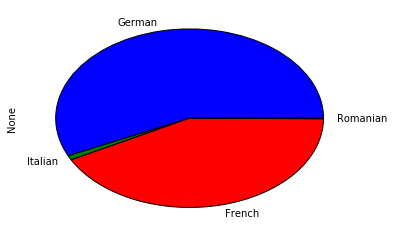

In [123]:
vis_rost=pd.Series(totals,index=ind_r)
vis_rost.plot.pie()

As we can see most of the grant goes to German speaking region which makes sense since it is by area largest. Then French and Italian follows while Romanian part gets very little.